In [35]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
import dlzh.d2lzh_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.4.0


In [36]:
'''
STEP1. read the train and test data
    train data contain with 1460 samples, 80 features and 1 labels
    test data contains witn 1459 samples and 80 features and we need to predicate 
    each test sample's lable
'''

train_data=pd.read_csv('./Data/train.csv')
test_data=pd.read_csv('././Data/test.csv')
print(train_data.shape,test_data.shape)
#这里的iloc函数查看前四个样本的前四个和后俩features以及最后一个标签
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])
#将训练数据和测试数据合并在一起
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(train_data)

(1460, 81) (1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
5        6          50       RL         85.0    14115   Pave   NaN      IR1   
6        7          20       RL         75.0    10084  

In [37]:
'''
STEP2. 预处理数据
'''
'''
对连续数值的特征做标准化：将连续性特征的值先减去均值再除以标准差，对于缺失值
'''
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

'''
将离散化数值转化为只是特征，比如MSZonlong中有俩离散值 RL和RM，将MSZonlong删除，转换为MSZonlng_RL
和MSZonlng_RM，他们的值分别为0或者1
'''
all_features=pd.get_dummies(all_features,dummy_na=True)
print(all_features.shape)

n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)
#这里的values属性是将pd的series转换为np的ndarray

(2919, 331)


In [38]:
'''
STEP3. 训练模型
'''
'''
这里使用基本的线性模型和平方损失函数来训练模型
'''
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net
'''
这里的损失函数使用对数均方根作为损失函数
L=sqrt(1/n*sum(log(yi)-log(y'i))^2)
'''
def log_rmse(net, features, labels):
    with torch.no_grad():
    # 将小于1的设置为1，使得取对数更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(),
        labels.log()).mean())
    return rmse.item()


def train(net, train_features, train_labels, test_features,test_labels,
num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size,shuffle=True)
    optimizer = torch.optim.Adam(params=net.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features,test_labels))
    return train_ls,test_ls
            

In [39]:
'''K fold cross validation'''
def get_k_fold_data(k, i, X, y):
    # 返回第i fold交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse 0.241266, valid rmse 0.221943
fold 1, train rmse 0.229501, valid rmse 0.269494
fold 2, train rmse 0.231829, valid rmse 0.238375
fold 3, train rmse 0.237360, valid rmse 0.218436
fold 4, train rmse 0.230784, valid rmse 0.258877
5-fold validation: avg train rmse 0.234148, avg valid rmse 0.241425


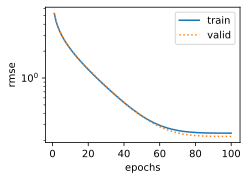

In [42]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels,
                          num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' %(k, train_l, valid_l))


train rmse 0.229348


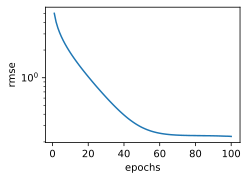

In [43]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)
    
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)